# Machine learning of ab-initio energy landscapes for crystal structure predictions

Shreyas Honrao, Bryan E. Anthonio, Rohit Ramanathan, Joshua J. Gabriel, Richard G. Hennig

In [82]:
import pickle 
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [2]:
data = pickle.load(open("data/cleanedData.pickle", "rb"))
print ("The total number of basin groups are", len(data))
print ("Sample conposition",data[10][0][2])

The total number of basin groups are 673
Sample conposition {'Li': 0.6, 'Ge': 0.4}


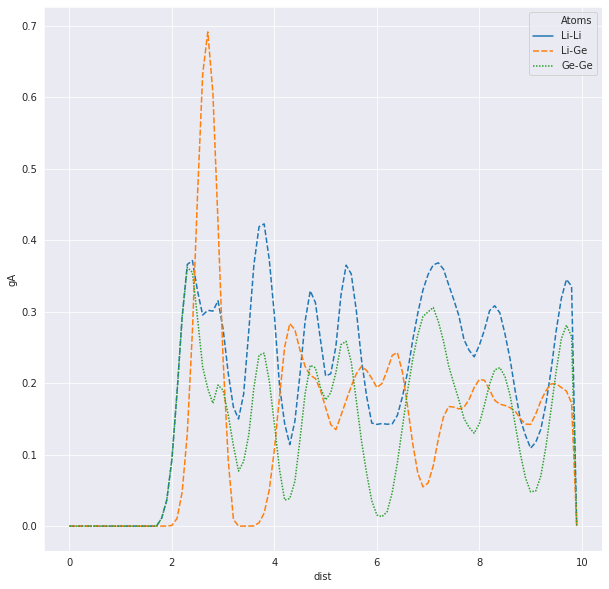

In [3]:
ele = 10
#np.shape(data[0][0][0][0])
atom_composition = []
values = []
distance = []
plotter = pd.DataFrame()

values.extend(data[ele][0][0][0])
atom_composition.extend(['Li-Li']*100)
distance.extend(np.arange(0, 10, 0.1))

values.extend(data[ele][0][0][1])
atom_composition.extend(['Li-Ge']*100)
distance.extend(np.arange(0, 10, 0.1))

values.extend(data[ele][0][0][2])
atom_composition.extend(['Ge-Ge']*100)
distance.extend(np.arange(0, 10, 0.1))

plotter['gA'] = values
plotter['dist'] = distance
plotter['Atoms'] = atom_composition
sns.set_style("darkgrid")
plt.figure(figsize=(10, 10))
ax = sns.lineplot(data=plotter,x='dist',y='gA',hue='Atoms',style='Atoms')
ax.lines[0].set_linestyle("--")
plt.show()

In [4]:
np.random.shuffle(data)

In [5]:
print ("Sample conposition after shuffling",data[0][0][2])

Sample conposition after shuffling {'Li': 0.7142857142857143, 'Ge': 0.2857142857142857}


In [6]:
#Parameters SVR for training and testing. Accoring to the paper

group_train_test_split = 200
c = 5
g = 0.001
eta = 0.01
num_epochs = 50

param_dist = {'C': scipy.stats.expon(scale=c), 'gamma': scipy.stats.expon(scale=g), 'kernel': ['rbf']}


In [7]:
train_group = data[0:group_train_test_split]
test_group = data[group_train_test_split:]

train_group = list(itertools.chain(*train_group))
test_group = list(itertools.chain(*test_group)) 

print (len(train_group),len(test_group))

print (np.shape(train_group))

4257 9911
(4257, 5)


In [16]:
import sklearn
from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import RandomizedSearchCV as CV
from sklearn.svm import SVR


X_train = list(zip(*train_group))[0]
X_train = list( map(np.ndarray.flatten, X_train))
y_train = list(zip(*train_group))[1]


X_test = list(zip(*test_group))[0]
X_test = list( map(np.ndarray.flatten, X_test))
y_test = list(zip(*test_group))[1]


print (np.shape(X_train))


# Feature Scaling
scaler = SS().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

svr = CV(SVR(epsilon=eta), param_distributions=param_dist, cv=5, scoring='neg_mean_squared_error', 
                  n_iter=num_epochs, n_jobs=-1)


print (np.shape(y_train))

clf = svr.fit(X_train,y_train)
print (np.shape(X_test))
clf_best = clf.best_estimator_

y_pred = clf_best.predict(X_test)

print (np.shape(y_test),np.shape(y_pred))


rms = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))
mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
r2 = sklearn.metrics.r2_score(y_test,y_pred)


print ("The RMS score is in mEV",rms*1000)
print ("The MAE score is in mEV",mae*1000)
print ("The r squared score is", r2)



(4257, 300)
(4257,)
(9911, 300)
(9911,) (9911,)
The RMS score is in mEV 21.40119452752941
The MAE score is in mEV 12.122726603690596
The r squared score is 0.9794978541910693


<Figure size 720x720 with 0 Axes>

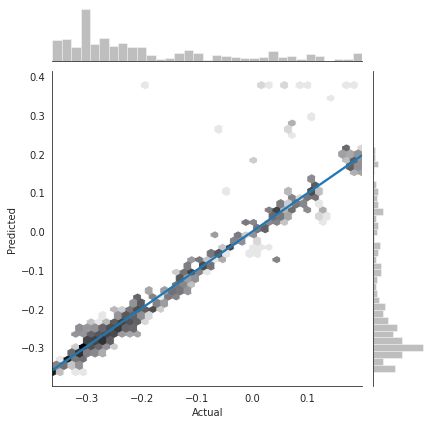

In [23]:
plotter = pd.DataFrame()
plotter['Actual'] = y_test
plotter['Predicted'] = y_pred

sns.set_style("white")
plt.figure(figsize=(10, 10))
g = sns.jointplot(x='Actual', y='Predicted', kind="hex", color="#5d5d60",
                  joint_kws={'gridsize':40, 'bins':'log'}, data=plotter)
ax = sns.regplot(x='Actual', y='Predicted', ax=g.ax_joint, scatter=False,data=plotter)
plt.show()

In [33]:
li_fraction = []
type_value = []
value = []

for i in list(zip(*test_group))[2]:
    li_fraction.append(i['Li'])

plotter = pd.DataFrame()
type_value.extend(['SVR']*len(y_pred))
value.extend(y_pred)
li_fraction.extend(li_fraction)
type_value.extend(['DFT']*len(y_test))
value.extend(y_test)

plotter['Formation Energy'] = value
plotter['Li Fraction'] = li_fraction
plotter['Type of value'] = type_value


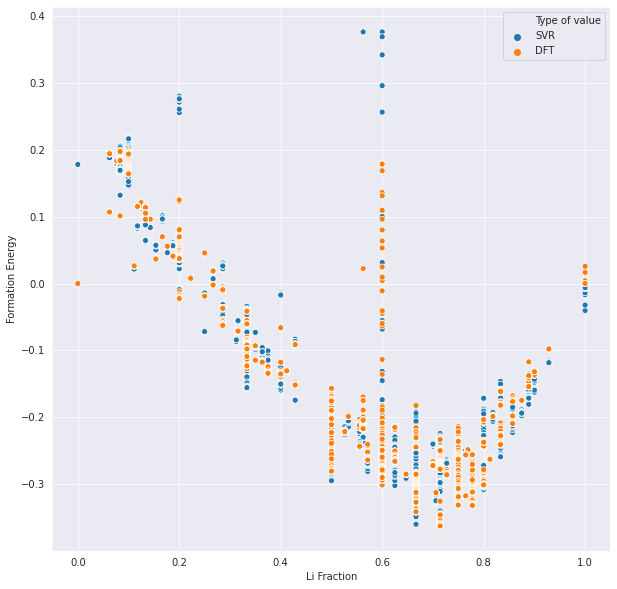

In [37]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data=plotter,x='Li Fraction',y='Formation Energy',hue='Type of value')
plt.show()

In [65]:
#Parameters KRR for training and testing. Accoring to the paper

group_train_test_split = 200
a = 1
g = 0.05
#eta = 0.01
num_epochs = 5

param_dist = {'alpha': scipy.stats.expon(scale=a), 'gamma': scipy.stats.expon(scale=g)}

gam = scipy.stats.expon(scale=g)


In [66]:
import sklearn
from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import RandomizedSearchCV as CV
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF

X_train = list(zip(*train_group))[0]
X_train = list( map(np.ndarray.flatten, X_train))
y_train = list(zip(*train_group))[1]


X_test = list(zip(*test_group))[0]
X_test = list( map(np.ndarray.flatten, X_test))
y_test = list(zip(*test_group))[1]


print (np.shape(X_train))


# Feature Scaling
scaler = SS().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#kernel = 1.0 * RBF(0.7)

svr = CV(KernelRidge(kernel='rbf'), param_distributions=param_dist, cv=5, scoring='neg_mean_squared_error', 
                  n_iter=num_epochs, n_jobs=-1)


print (np.shape(y_train))

clf = svr.fit(X_train,y_train)
print (np.shape(X_test))
clf_best = clf.best_estimator_

y_pred = clf_best.predict(X_test)

print (np.shape(y_test),np.shape(y_pred))


rms = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))
mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
r2 = sklearn.metrics.r2_score(y_test,y_pred)


print ("The RMS score is in mEV",rms*1000)
print ("The MAE score is in mEV",mae*1000)
print ("The r squared score is", r2)



(4257, 300)
(4257,)
(9911, 300)
(9911,) (9911,)
The RMS score is in mEV 22.569720660640446
The MAE score is in mEV 15.612859583288722
The r squared score is 0.9771978574372383


<Figure size 720x720 with 0 Axes>

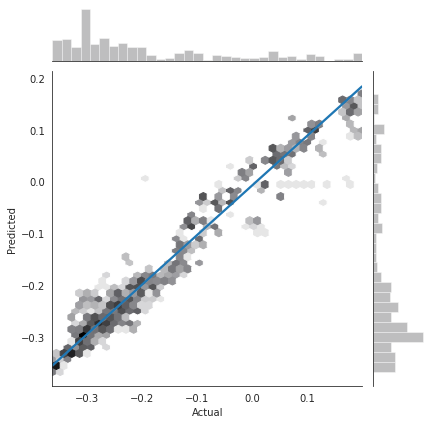

In [67]:
plotter = pd.DataFrame()
plotter['Actual'] = y_test
plotter['Predicted'] = y_pred

sns.set_style("white")
plt.figure(figsize=(10, 10))
g = sns.jointplot(x='Actual', y='Predicted', kind="hex", color="#5d5d60",
                  joint_kws={'gridsize':40, 'bins':'log'}, data=plotter)
ax = sns.regplot(x='Actual', y='Predicted', ax=g.ax_joint, scatter=False,data=plotter)
plt.show()

In [70]:
li_fraction = []
type_value = []
value = []

for i in list(zip(*test_group))[2]:
    li_fraction.append(i['Li'])

plotter = pd.DataFrame()
type_value.extend(['KRR']*len(y_pred))
value.extend(y_pred)
li_fraction.extend(li_fraction)
type_value.extend(['DFT']*len(y_test))
value.extend(y_test)

plotter['Formation Energy'] = value
plotter['Li Fraction'] = li_fraction
plotter['Type of value'] = type_value


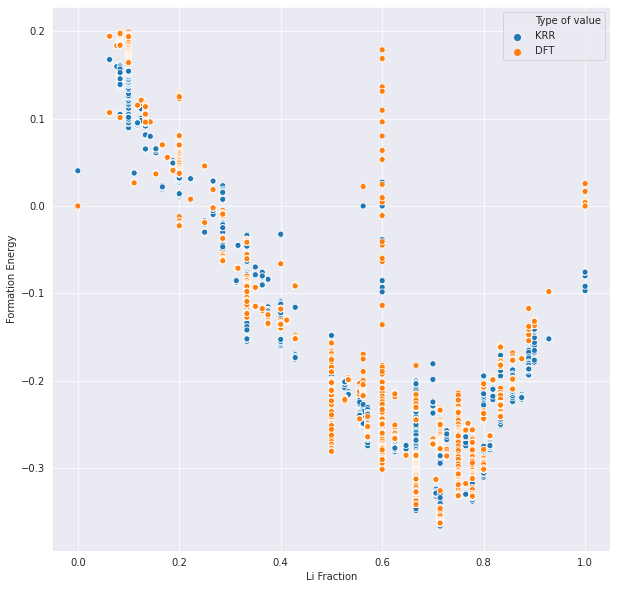

In [71]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data=plotter,x='Li Fraction',y='Formation Energy',hue='Type of value')
plt.show()

In [76]:
#Parameters SVR for training and testing. Accoring to the paper

group_train_test_split = 200
c = 5
g = 0.001
eta = 0.01
num_epochs = 50

param_dist = {'C': scipy.stats.expon(scale=c), 'gamma': scipy.stats.expon(scale=g), 'kernel': ['rbf']}


In [85]:
group_train_test_split = 500

size_arr = []
rmse_arr = []

train_group = data[0:group_train_test_split]
test_group = data[group_train_test_split:]

train_group = list(itertools.chain(*train_group))
test_group = list(itertools.chain(*test_group)) 



for size in tqdm(range(500,8000,50)):


    X_train = list(zip(*train_group))[0]
    X_train = list( map(np.ndarray.flatten, X_train[0:size]))
    y_train = list(zip(*train_group[0:size]))[1]


    X_test = list(zip(*test_group))[0]
    X_test = list( map(np.ndarray.flatten, X_test))
    y_test = list(zip(*test_group))[1]


    


    # Feature Scaling
    scaler = SS().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    svr = CV(SVR(epsilon=eta), param_distributions=param_dist, cv=5, scoring='neg_mean_squared_error', 
                      n_iter=num_epochs, n_jobs=-1)


    

    clf = svr.fit(X_train,y_train)
    #print (np.shape(X_test))
    clf_best = clf.best_estimator_

    y_pred = clf_best.predict(X_test)

    #print (np.shape(y_test),np.shape(y_pred))


    rms = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))
    mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
    r2 = sklearn.metrics.r2_score(y_test,y_pred)

    rmse_arr.append(rms*1000)
    size_arr.append(size)
#     print ("The RMS score is in mEV",rms*1000)
#     print ("The MAE score is in mEV",mae*1000)
#     print ("The r squared score is", r2)



100%|██████████| 150/150 [3:12:45<00:00, 77.10s/it]   


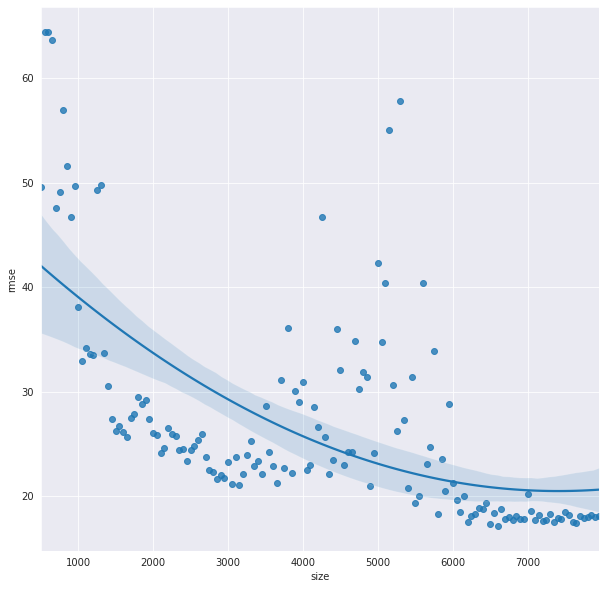

In [108]:
plotter = pd.DataFrame()
plotter['rmse'] = rmse_arr
plotter['size'] = size_arr

sns.set_style("darkgrid")
plt.figure(figsize=(10, 10))
ax = sns.regplot(data=plotter,x='size',y='rmse',order=2)
plt.show()

In [282]:
data = pickle.load(open("data/cleanedData.pickle", "rb"))
print ("The total number of basin groups are", len(data))
print ("Sample conposition",data[10][0][2])

The total number of basin groups are 673
Sample conposition {'Li': 0.6, 'Ge': 0.4}


In [283]:
for dftGroup in data:
    for step in dftGroup:
        step[1] = dftGroup[len(dftGroup)-1][1] #Replace energy with energy of last step in dftGroup


In [284]:
np.random.shuffle(data)

group_train_test_split = 200
train_g = data[0:group_train_test_split]
test_g = data[group_train_test_split:]



In [285]:
#Parameters SVR for training and testing. Accoring to the paper

group_train_test_split = 200
c = 5
g = 0.001
eta = 0.01
num_epochs = 50

param_dist = {'C': scipy.stats.expon(scale=c), 'gamma': scipy.stats.expon(scale=g), 'kernel': ['rbf']}


In [286]:
import sklearn
from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import RandomizedSearchCV as CV
from sklearn.svm import SVR




train_group = list(itertools.chain(*train_g))
X_train = list(zip(*train_group))[0]
X_train = list( map(np.ndarray.flatten, X_train))
y_train = list(zip(*train_group))[1]

y_total = []

test_group = list(itertools.chain(*test_g)) 
X_test = list(zip(*test_group))[0]
X_test = list( map(np.ndarray.flatten, X_test))
y_test = list(zip(*test_group))[1]


print (np.shape(X_train))


# Feature Scaling
scaler = SS().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

svr = CV(SVR(epsilon=eta), param_distributions=param_dist, cv=5, scoring='neg_mean_squared_error', 
                  n_iter=num_epochs, n_jobs=-1)


print (np.shape(y_train))

clf = svr.fit(X_train,y_train)
print (np.shape(X_test))
clf_best = clf.best_estimator_

y_pred = clf_best.predict(X_test)
y_train_pred = clf_best.predict(X_train)

#y_total.extend(y_train_pred)
y_total.extend(y_pred)


print (np.shape(y_test),np.shape(y_pred))


rms = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))
mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
r2 = sklearn.metrics.r2_score(y_test,y_pred)


print ("The RMS score is in mEV",rms*1000)
print ("The MAE score is in mEV",mae*1000)
print ("The r squared score is", r2)

li_fraction = []
for i in list(zip(*test_group))[2]:
    li_fraction.append(i['Li'])

svr_points = list(zip(li_fraction,y_total))
svr_points = np.array(svr_points)

svr_hull = ConvexHull(svr_points)



(4711, 300)
(4711,)
(9457, 300)
(9457,) (9457,)
The RMS score is in mEV 17.933289786551615
The MAE score is in mEV 12.457553012221116
The r squared score is 0.9855778141818038


<Figure size 720x720 with 0 Axes>

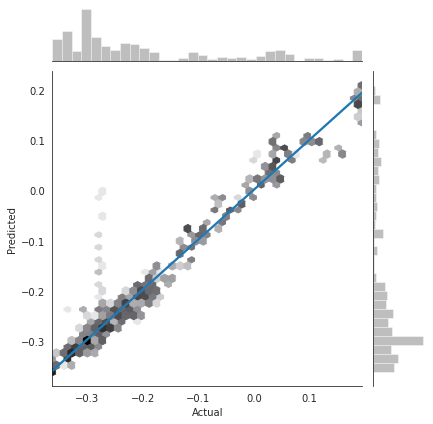

In [287]:
plotter = pd.DataFrame()
plotter['Actual'] = y_test
plotter['Predicted'] = y_pred

sns.set_style("white")
plt.figure(figsize=(10, 10))


g = sns.jointplot(x='Actual', y='Predicted', kind="hex", color="#5d5d60",
                  joint_kws={'gridsize':40, 'bins':'log'}, data=plotter)
ax = sns.regplot(x='Actual', y='Predicted', ax=g.ax_joint, scatter=False,data=plotter)
plt.show()

In [288]:

type_value = []
value = []

plotter = pd.DataFrame()
type_value.extend(['SVR']*len(y_pred))
value.extend(y_pred)
li_fraction.extend(li_fraction)
type_value.extend(['DFT']*len(y_test))
value.extend(y_test)

plotter['Formation Energy'] = value
plotter['Li Fraction'] = li_fraction
plotter['Type of value'] = type_value




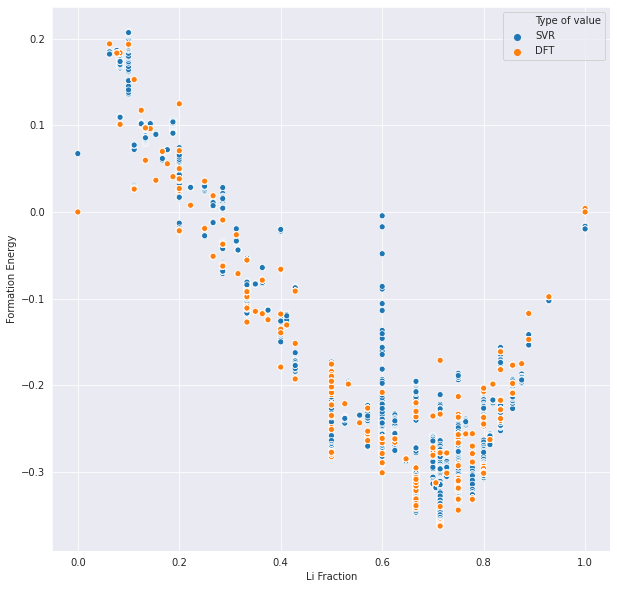

In [289]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data=plotter,x='Li Fraction',y='Formation Energy',hue='Type of value')
plt.show()

In [290]:
#Parameters KRR for training and testing. Accoring to the paper
group_train_test_split = 200
a = 1
g = 0.05
#eta = 0.01
num_epochs = 50

param_dist = {'alpha': scipy.stats.expon(scale=a), 'gamma': scipy.stats.expon(scale=g)}

gam = scipy.stats.expon(scale=g)


In [291]:
import sklearn
from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import RandomizedSearchCV as CV
from sklearn.svm import SVR




train_group = list(itertools.chain(*train_g))
X_train = list(zip(*train_group))[0]
X_train = list( map(np.ndarray.flatten, X_train))
y_train = list(zip(*train_group))[1]

y_total = []

test_group = list(itertools.chain(*test_g)) 
X_test = list(zip(*test_group))[0]
X_test = list( map(np.ndarray.flatten, X_test))
y_test = list(zip(*test_group))[1]


print (np.shape(X_train))


# Feature Scaling
scaler = SS().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

krr = CV(KernelRidge(kernel='rbf'), param_distributions=param_dist, cv=5, scoring='neg_mean_squared_error', 
                  n_iter=num_epochs, n_jobs=-1)


print (np.shape(y_train))

clf = krr.fit(X_train,y_train)
print (np.shape(X_test))
clf_best = clf.best_estimator_

y_pred = clf_best.predict(X_test)
y_train_pred = clf_best.predict(X_train)

#y_total.extend(y_train_pred)
y_total.extend(y_pred)


print (np.shape(y_test),np.shape(y_pred))


rms = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))
mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
r2 = sklearn.metrics.r2_score(y_test,y_pred)


print ("The RMS score is in mEV",rms*1000)
print ("The MAE score is in mEV",mae*1000)
print ("The r squared score is", r2)

li_fraction = []
for i in list(zip(*test_group))[2]:
    li_fraction.append(i['Li'])

krr_points = list(zip(li_fraction,y_total))
krr_points = np.array(krr_points)

krr_hull = ConvexHull(krr_points)



(4711, 300)
(4711,)
(9457, 300)
(9457,) (9457,)
The RMS score is in mEV 23.12997734296883
The MAE score is in mEV 16.12987910064715
The r squared score is 0.9760082698070165


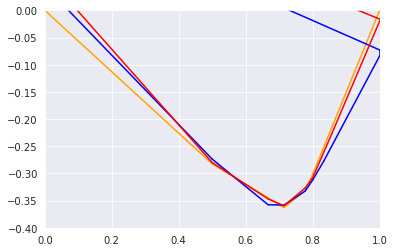

In [298]:
from scipy.spatial import ConvexHull
y_total = []
#y_total.extend(y_train)
y_total.extend(y_test)


k = list(zip(li_fraction,y_total))
k = np.array(k)

hull = ConvexHull(k)
plt.ylim([-0.4,0.0])
plt.xlim([0.0,1.0])
#plt.plot(k[:,0], k[:,1], 'o')
for simplex in hull.simplices:
    #print (k[simplex, 1])
    plt.plot(k[simplex, 0], k[simplex, 1], 'k-',c='orange')

    
for simplex in krr_hull.simplices:
    plt.plot(krr_points[simplex, 0], krr_points[simplex, 1], 'k-',c='blue')

for simplex in svr_hull.simplices:
    plt.plot(svr_points[simplex, 0], svr_points[simplex, 1], 'k-',c='red')


# plotter['y'] = ConvexHull(k)
# plotter['x'] = li_fraction
# #plotter['dist'] = distance
# #plotter['Atoms'] = atom_composition
# sns.set_style("darkgrid")
# plt.figure(figsize=(10, 10))
# ax = sns.lineplot(data=plotter,x='x',y='y')
# ax.lines[0].set_linestyle("--")
# plt.show()